<a href="https://colab.research.google.com/github/Benendead/LSTMjazz/blob/master/Research/My_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
Author(s) | Year | Models Used | Music | Encoding | Quantization | Future work | Code/Examples
--- | ---
Eck | 2002 | LSTM | Melody + chords | 13 melody, 12 chord 1/0 | 2 per beat | N/A | [Ex](https://web.archive.org/web/20190104192500/http://people.idsia.ch/~juergen/blues/)
Bickerman | 2010 | DBN | Chords -> jazz licks | 18 melody (12 pitch, 4 8va), 12 chord | 12 per beat | Melodies avoid triplets | [Code](https://sourceforge.net/projects/rbm-provisor/)
Choi | 2016 | char-RNN, word-RNN | Jazz chord progressions | Note chars, Chord words | 1 per beat | N/A | [Code](https://github.com/keunwoochoi/lstm_real_book)
Lackner | 2016 | LSTM | Melody given chords | 24 melody, 12 chord 1/0 | 4 per beat | Larger dataset | [Ex](https://konstilackner.github.io/LSTM-RNN-Melody-Composer-Website/)
Agarwala | 2017 | Seq2Seq, char-RNN | Melodies | ABC char -> embeddings | None; ABC notation | N/A | [Code](https://github.com/yinoue93/CS224N_proj)
Brunner | 2017 | 2 LSTMs | Chords -> polyphonic piano | 48 melody, 50 chord embeddings | 2 per beat | Encoding polyphonic sustain, genre metadata | N/A
Hilscher | 2018 | char-RNN | Polyphonic piano | 1/0 on/off vectors | 4 per beat | More keys/data, text pattern matching | [Ex](https://yellow-ray.de/~moritz/midi_rnn/examples.html)

**To Consider:**
* My representation needs to have at least 12 steps per beat; triplets AND sixteenth notes are needed.
* Chords --> Melody has only one precedent for best practices.
* 2 of the 7 used chord embeddings.
* Methods to check overfitting are limited so far.
* 3 of the 7 benefitted from transposing to multiple keys.

# Code Setup and Data Import

We import the necessary libraries, create a method to tranpose imported songs to C, and then import all songs.

In [1]:
!pip install music21

import music21 as m21
import glob

!git clone https://github.com/Benendead/LSTMjazz/

Cloning into 'LSTMjazz'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 288 (delta 76), reused 0 (delta 0), pack-reused 139
Receiving objects: 100% (288/288), 723.51 KiB | 7.38 MiB/s, done.
Resolving deltas: 100% (137/137), done.


In [0]:
def formatStream(stream):
  m21.harmony.realizeChordSymbolDurations(stream)           # Fills out chords' proper durations.
  key = stream.analyze("key")                               # Finds how far off we are from C.
  i = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
  transposedStream = stream.transpose(i)                    # Transposes us that far to C.
  return transposedStream

In [4]:
# Import the songs and transpose them all to C.

streams = []
names = []
i = 1

# Selects all .xml files in the Datasets folder.
for xml_file in glob.glob("LSTMjazz/Datasets/*/*.xml"):
    if (i == 1 or i % 10 == 0):
      print("Processing song", i, ":", xml_file)
    newSong = m21.converter.parse(xml_file)
    formattedSong = formatStream(newSong)
    streams.append(formattedSong)
    songName = xml_file[32:-4]  # Formats xml_file to get the name of the song.
    names.append(songName)
    i = i + 1

Processing song 1 : LSTMjazz/Datasets/Omnibook Mxml/Cosmic_Rays.xml
Processing song 10 : LSTMjazz/Datasets/Omnibook Mxml/Another_Hairdo.xml
Processing song 20 : LSTMjazz/Datasets/Omnibook Mxml/Now's_The_Time_2.xml
Processing song 30 : LSTMjazz/Datasets/Omnibook Mxml/Marmaduke.xml
Processing song 40 : LSTMjazz/Datasets/Omnibook Mxml/Billies's_Bounce.xml
Processing song 50 : LSTMjazz/Datasets/Omnibook Mxml/Card_Board.xml


We now have all songs imported, transposed to C, and with fully realized chord durations.  
Rather than one copy of each song in C, let's create 12 copies of each song transposed to all 12 keys.

In [0]:
import random

def transposeRandom(stream):
  """
  Transposes a given stream to a random key.
  """
  half_steps = random.randint(0,12) # Random number 0 to 11.
  i = m21.interval.Interval(half_steps)
  transposedStream = stream.transpose(i)
  return transposedStream

In [0]:
def transpose12(stream):
  """
  Returns a list of all 12 tranpositions of the given stream.
  """
  output = []
  for k in range(0,12):
    half_steps = k
    i = m21.interval.Interval(half_steps)
    transposedStream = stream.transpose(i)
    output.append(transposedStream)
  return output

In [7]:
expanded_streams = [] # This will have every transposed song in it; 600 total.
for stream_n in range(0,len(streams)):
  s = streams[stream_n]
  if (stream_n == 0 or stream_n % 5 == 4):
    print("Replicating song", (stream_n + 1))
  transposed_list = transpose12(s)
  expanded_streams.extend(transposed_list)
    
print("We have", 12*len(streams), "total songs.")

Replicating song 1
Replicating song 5
Replicating song 10
Replicating song 15
Replicating song 20
Replicating song 25
Replicating song 30
Replicating song 35
Replicating song 40
Replicating song 45
Replicating song 50
We have 600 total songs.


# Basic Dataset Analysis

Let's check out how long our songs are, as well as the range of their pitches.

In [0]:
def getDuration(stream):
  """
  Takes a Music21 stream and returns the total length of the chords in the stream.
  """
  part = stream.parts[0]
  sumDuration = 0
  
  for m in part:                                            # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      for c in m.notes:
        if isinstance(c, m21.harmony.ChordSymbol):          # For the chords...
          sumDuration = sumDuration + c.duration.quarterLength
  
  return sumDuration

In [9]:
durations = []

total = 0
for s in expanded_streams:
  duration = getDuration(s)
  durations.append(duration)
  total = total + duration
  
print("We have", total, "total beats of data.")

We have 169008.0 total beats of data.


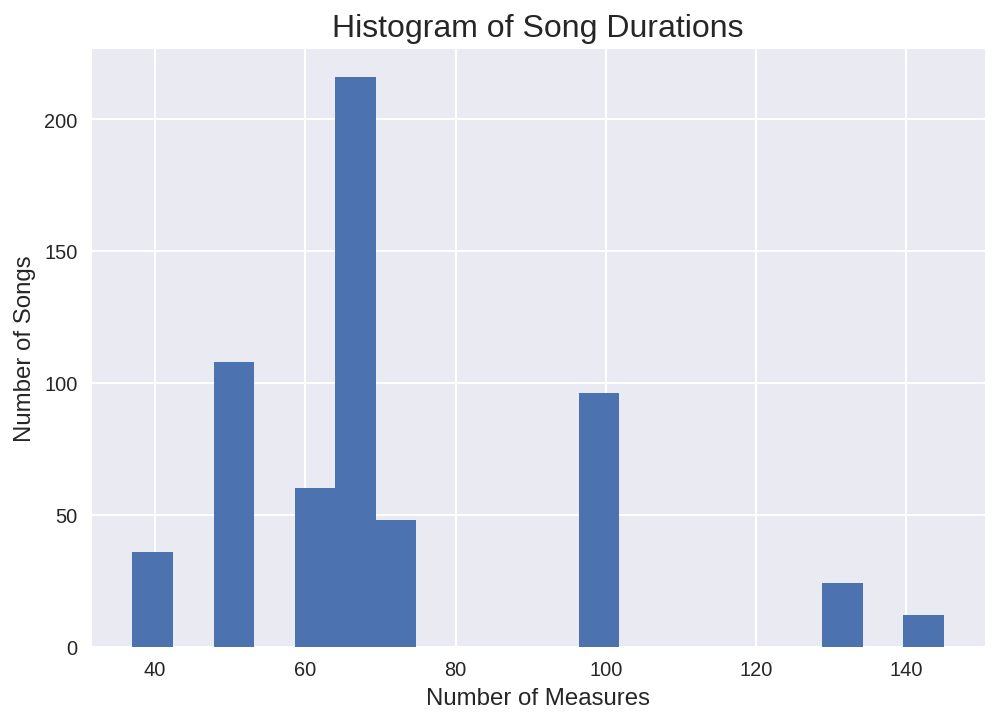

In [10]:
# Some insight into the durations of the songs we have.

import matplotlib.pyplot as plt
import numpy as np

n_bins = 20
x = np.array(durations) / 4

fig, ax = plt.subplots()

plt.title("Histogram of Song Durations", fontsize = 16)
plt.xlabel("Number of Measures", fontsize = 12)
plt.ylabel("Number of Songs", fontsize = 12)

hist = ax.hist(x, bins = n_bins) # We can set the number of bins for the histogram with the "bins" kwarg

Let's also check the keys of our randomly transposed songs:

In [0]:
def getKey(stream):
  """
  Returns the key of the given stream as an int 0-11, with C = 0 and B = 11.
  """
  key = stream.analyze("key")  # A music21.key.Key object.
  tonic = key.tonic            # A music21.pitch.Pitch object.
  return tonic.pitchClass

Processing song  1
Processing song  50
Processing song  100
Processing song  150
Processing song  200
Processing song  250
Processing song  300
Processing song  350
Processing song  400
Processing song  450
Processing song  500
Processing song  550
Processing song  600


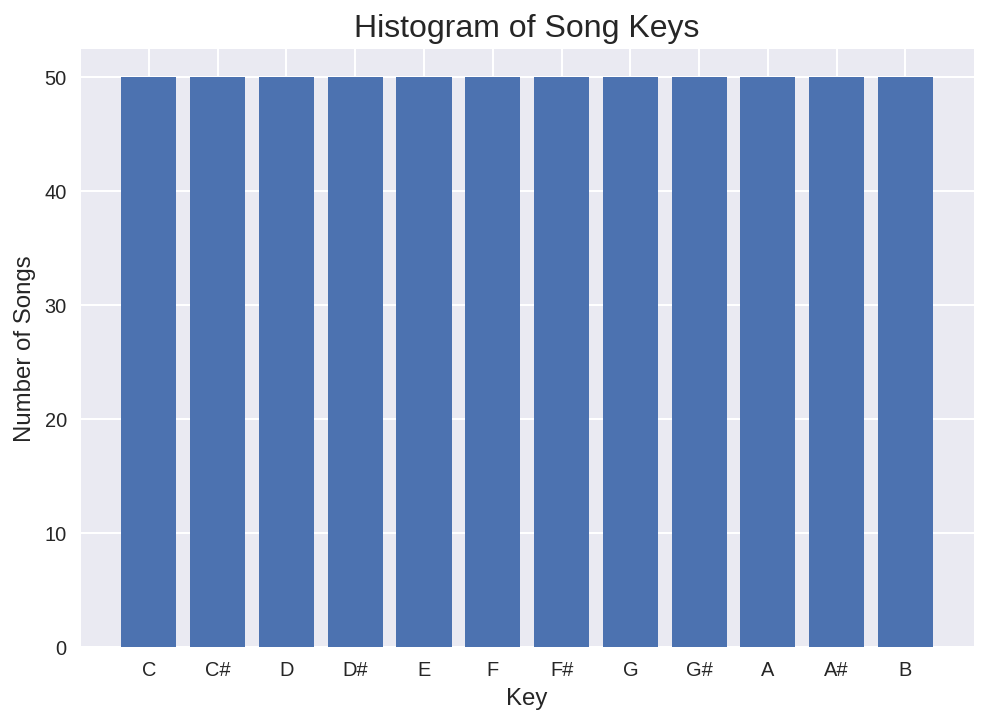

In [12]:
# Some insight into the keys of the songs we have.

keys = [0] * 12
counter = 1
for s in expanded_streams:
  if (counter == 1 or counter % 50 == 0):
    print("Processing song ", counter)
  k = getKey(s)
  keys[k] = keys[k] + 1
  counter = counter + 1

fig, ax = plt.subplots()

plt.title("Histogram of Song Keys", fontsize = 16)
plt.xlabel("Key", fontsize = 12)
plt.ylabel("Number of Songs", fontsize = 12)
plt.xticks(range(0,12), ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'), fontsize = 10)

bar = ax.bar(range(0,12), keys)

We can see the duration and key of the songs we have, but what other metrics inform us about the melodies and harmonies within these songs? Let's look into what chords these songs now use. First, we want to find the "vocabulary" of the chords present. This entails adding one copy of each unique chord into a list.

In [0]:
def uniqueChords(stream):
  """
  Returns a list of strings representing the unique chords in this song.
  The bits in each string represent the 12 possible chord notes.
  """
  chords = []
  
  part = stream.parts[0]
  
  # Collect the chords in the song.
  for m in part:                                     # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      for c in m.notes:
        if isinstance(c, m21.harmony.ChordSymbol):   # If this object is a chord...

          encoding = [0] * 12
          for p in c.pitches:
            p.octave = 4
            num = int(p.midi - 60) % 12              # num will range from 0 to 11.
            encoding[num] = 1
          
          string = ""
          for n in encoding:
            string = string + str(n)
          
          if string not in chords:
            chords.append(string)
  return chords

In [0]:
def combineSets(set1, set2):
  """
  Combines the contents of two sets as to keep all elements unique.
  NOTE: Faster if set2 is the shorter one.
  """
  for e in set2:
    if e not in set1:
      set1.append(e)
  return set1

It's now time to find all unique chords in each song and then merge all 600 of these sets.

In [15]:
uniqueChordSet = []

counter = 1
for s in expanded_streams:
  if (counter == 1 or counter % 5 == 0):
    print("Working through song " + str(counter) + "'s chords.")
  newChords = uniqueChords(s)
  uniqueChordSet = combineSets(uniqueChordSet, newChords)
  counter = counter + 1
  
print("We have", len(uniqueChordSet), "unique chords.")

Working through song 1's chords.
Working through song 5's chords.
Working through song 10's chords.
Working through song 15's chords.
Working through song 20's chords.
Working through song 25's chords.
Working through song 30's chords.
Working through song 35's chords.
Working through song 40's chords.
Working through song 45's chords.
Working through song 50's chords.
Working through song 55's chords.
Working through song 60's chords.
Working through song 65's chords.
Working through song 70's chords.
Working through song 75's chords.
Working through song 80's chords.
Working through song 85's chords.
Working through song 90's chords.
Working through song 95's chords.
Working through song 100's chords.
Working through song 105's chords.
Working through song 110's chords.
Working through song 115's chords.
Working through song 120's chords.
Working through song 125's chords.
Working through song 130's chords.
Working through song 135's chords.
Working through song 140's chords.
Working

So there we have it: 72 unique chords. We'll choose a vocabulary size of 72 to encode each of these with a unique integer representation, which we can then use as inputs to an embedding layer. We can find the corresponding index to each chord by using .index() to find the chord strings in uniqueChordSet.

In [0]:
def findInt(string):
  return uniqueChordSet.index(string)